  # Implementing  and Pruning Apriori in Python

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [3]:
%store -r predict_dataset

In [4]:
predict_df = predict_dataset

In [5]:
def generate_appwords():
    stpwrds = ["app", "alexa", "facebook", 
                     "googlehome", "instagram", "linkedin", "tiktok", "tik", "tok", "uber", "youtube", "fb", 
               "dont", "yall", "kinda", "lot", "anymore", "doesnt", "tube", "blm", "thing"]
    return stpwrds

In [6]:
def remove_stopwords(text, stpwrds):
    #text = text.split(" ")
    words = [w for w in text if w not in stpwrds]
    return words

In [7]:
stpwrds = generate_appwords()
predict_df['clean_content'] = predict_df['clean_content'].apply(lambda x: remove_stopwords(x, stpwrds))

In [8]:
predict_df['clean_content']

2                                      [love, im, addict]
3       [pedophile, act, underage, half, naked, girl, ...
8                                       [addict, af, tbh]
14      [love, help, pass, time, lose, bit, time, gott...
17          [terrible, invade, privacy, badly, nightmare]
                              ...                        
2942    [driver, respond, pool, cancel, trip, bear, fine]
2944    [horrible, assign, driver, complete, trip, per...
2987    [bad, sound, audible, video, clear, appand, re...
3030    [restore, account, lose, picture, recipe, birt...
3054    [reason, act, stupid, make, video, login, put,...
Name: clean_content, Length: 417, dtype: object

In [9]:
# Create an empty dictionary to store the sub dataframes for each app
app_subdfs = {}

# Iterate over each unique app name
for app in predict_df['app_name'].unique():
    # Filter the dataframe for the current app
    sub_df = predict_df[predict_df['app_name'] == app]
    # Store the sub dataframe in the dictionary with the app name as the key
    app_subdfs[app] = sub_df

### One-hot encoding transaction data
corpus_list here transformed into a one-hot encoded data frame, where each column consists of true and false values that indicate whether a word was included in a review. 

In [10]:
app_corpus_list = {}
def create_corpus(df,  concern: bool = False):
    for app in app_subdfs.keys():
        if concern:
            for index, row in app_subdfs[app].iterrows():
                row["clean_content"].append(row["predicted"])
        corpus_list = app_subdfs[app]["clean_content"].tolist()
        app_corpus_list[app] = corpus_list
    return app_corpus_list

app_corpus_list = create_corpus(app_subdfs, concern=True)
app_corpus_list

{'tiktok': [['love', 'im', 'addict', 'addiction'],
  ['pedophile',
   'act',
   'underage',
   'half',
   'naked',
   'girl',
   'inappropriate',
   'content',
   'take',
   'trump',
   'video',
   'community',
   'guideline',
   'inappropriate content'],
  ['addict', 'af', 'tbh', 'addiction'],
  ['love',
   'help',
   'pass',
   'time',
   'lose',
   'bit',
   'time',
   'gotta',
   'make',
   'addiction'],
  ['terrible', 'invade', 'privacy', 'badly', 'nightmare', 'privacy'],
  ['addict', 'addiction'],
  ['fun',
   'watch',
   'everyday',
   'addict',
   'watch',
   'make',
   'video',
   'addiction'],
  ['love',
   'abuse',
   'privacy',
   'right',
   'lol',
   'yeah',
   'im',
   'concern',
   'entertainment',
   'meet',
   'awsome',
   'personality',
   'lolol',
   'lonny',
   'howe',
   'regina',
   'saskatchewan',
   'canada',
   'privacy'],
  ['addict', 'addiction'],
  ['horrible',
   'customer',
   'service',
   'follow',
   'community',
   'guideline',
   'dangerous',
   'med

In [11]:
# Create an empty dictionary to store the sub dataframes for each app
app_corpus_subdfs = {}
te = TransactionEncoder()
for app in app_subdfs.keys():
    print(app)
    te_ary = te.fit(app_corpus_list[app]).transform(app_corpus_list[app])
    corpus_df = pd.DataFrame(te_ary, columns=te.columns_)
    app_corpus_subdfs[app] = corpus_df
    print(corpus_df.shape)

tiktok
(182, 844)
facebook
(54, 463)
uber
(64, 588)
zoom
(11, 82)
vinted
(13, 89)
alexa
(4, 48)
googlehome
(3, 21)
linkedin
(11, 92)
instagram
(30, 209)
youtube
(45, 355)


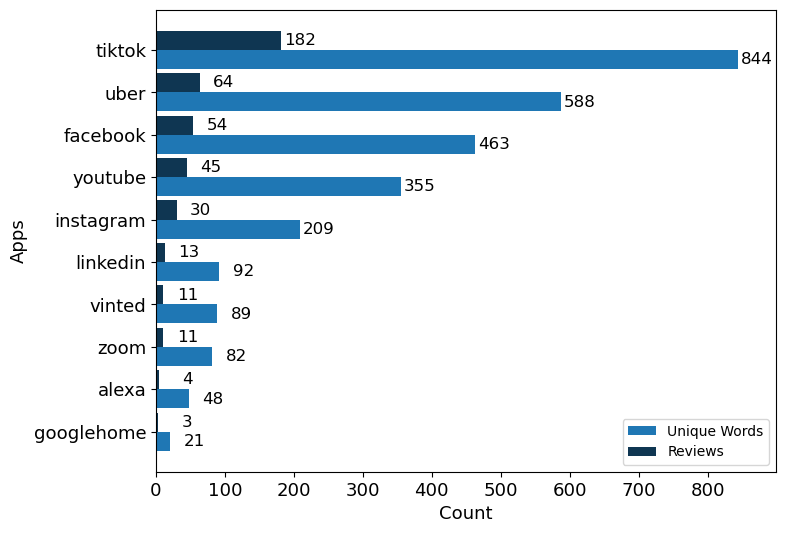

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create a list to store the number of unique words for each app
unique_words_app = {}

# Iterate over the sub-dataframes
for app, sub_df in app_corpus_subdfs.items():
    unique_words_app[app] = len(sub_df.columns)
unique_words_app = sorted(unique_words_app.items(), key=lambda x: x[1], reverse=True)
unique_words_app = dict(unique_words_app)
# Sort the unique_words_app dictionary by values in descending order
unique_words_app_list = sorted(unique_words_app.items(), key=lambda x: x[1], reverse=False)

# Create a list to store the number of reviews for each app
no_review_app = {}

# Iterate over the sub-dataframes
for app, sub_df in app_corpus_subdfs.items():
    no_review_app[app] = len(sub_df.index)
no_review_app = sorted(no_review_app.items(), key=lambda x: x[1], reverse=True)
no_review_app = dict(no_review_app)
# Sort the no_review_app dictionary by values in descending order
no_review_app_list = sorted(no_review_app.items(), key=lambda x: x[1], reverse=False)

# Extract the sorted apps and counts for unique words
apps_unique_words = [app for app, count in unique_words_app_list]
counts_unique_words = [count for app, count in unique_words_app_list]

# Extract the sorted apps and counts for reviews
apps_reviews = [app for app, count in no_review_app_list]
counts_reviews = [count for app, count in no_review_app_list]

# Set the width of the bars
bar_width = 0.45

# Create an array of indices for the x-axis ticks
ind = np.arange(len(apps_unique_words))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bars for unique words
bars_unique_words = ax.barh(ind, counts_unique_words, bar_width, color='#1f77b4', label='Unique Words')

# Plot the bars for reviews
bars_reviews = ax.barh(ind + bar_width, counts_reviews, bar_width, color='#0f3652', label='Reviews')

# Add value labels to each bar for unique words
for count, bar in zip(counts_unique_words, bars_unique_words):
    ax.text(bar.get_width() + 50 , bar.get_y() + bar.get_height() / 2 , str(count), ha='right', va='center', fontsize=12)

# Add value labels to each bar for reviews
for count, bar in zip(counts_reviews, bars_reviews):
    ax.text(bar.get_width() + 50 , bar.get_y() + bar.get_height() / 2 , str(count), ha='right', va='center', fontsize=12)

# Set the y-axis ticks and labels
ax.set_yticks(ind + bar_width / 2)
ax.set_yticklabels(apps_unique_words)

plt.xlabel('Count', fontsize=13)  # Increase font size to 12
plt.ylabel('Apps', fontsize=13)  # Increase font size to 12

# Increase font size of tick labels on both axes
ax.tick_params(axis='x', labelsize=13)  # Increase x-axis tick label font size to 10
ax.tick_params(axis='y', labelsize=13)  # Increase y-axis tick label font size to 10

# Set the chart title
#ax.set_title('Number of Unique Words and Reviews for Each App')
plt.xlim(0,899)
# Set the legend
ax.legend()

# Display the chart
plt.show()


### Remove some apps

In [13]:
del app_corpus_subdfs['googlehome']
del app_corpus_subdfs['zoom']
del app_corpus_subdfs['linkedin']
del app_corpus_subdfs['instagram']
del app_corpus_subdfs['alexa']
del app_corpus_subdfs['vinted']

In [14]:
app_corpus_subdfs.keys()

dict_keys(['tiktok', 'facebook', 'uber', 'youtube'])

In [15]:
app_corpus_subdfs.keys()

dict_keys(['tiktok', 'facebook', 'uber', 'youtube'])

### Frequency of the words & Support metric

In [16]:
te = TransactionEncoder()
app_word_counts_subdfs = {}
app_support_counts_subdfs = {}
for app in app_corpus_subdfs.keys():
    word_counts = app_corpus_subdfs[app].sum()
# Create a new dataframe to store the word counts
    word_counts_df = pd.DataFrame({'Word': word_counts.index, 'Count': word_counts.values})

# Calculate the total number of transactions
    total_transactions = len(app_corpus_subdfs[app].index)
# Calculate the support for each word
    word_counts_df['Support'] = word_counts_df['Count'] / total_transactions
    
# Sort the dataframe by the word support in descending order
    word_counts_df = word_counts_df.sort_values('Support', ascending=False)
    app_word_counts_subdfs[app] = word_counts_df
    #print(app_word_counts_subdfs)
    support_counts = word_counts_df.groupby(word_counts_df['Support'].round(3))['Word'].nunique().reset_index()
    app_support_counts_subdfs[app] = support_counts
    #print(app_support_counts_subdfs)


# Print the DataFrame with word counts and their respective supports
#word_counts_df
#app_support_counts_subdfs['youtube']


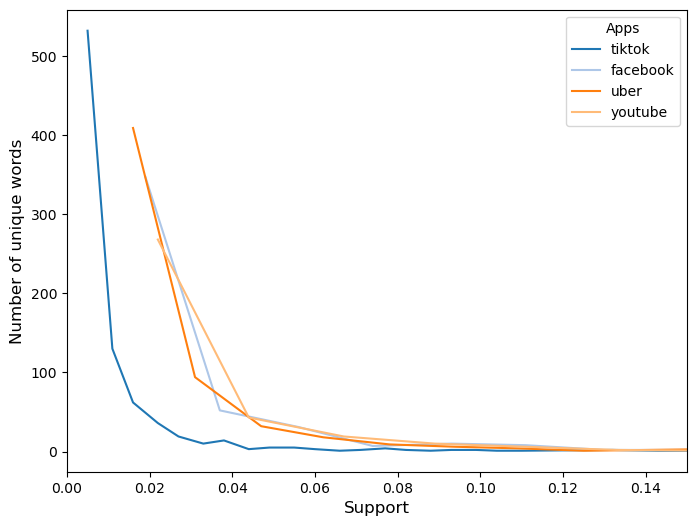

In [38]:
# Plot the number of unique words for each support value
import matplotlib.ticker as mticker

plt.figure(figsize=(8, 6))

color_palette = sns.color_palette("tab20", len(app_support_counts_subdfs.keys()))
for app, color in zip(app_support_counts_subdfs.keys(), color_palette):
    app_df = app_support_counts_subdfs[app]
    plt.plot(app_df['Support'], app_df['Word'], color=color,  label=app)

plt.xlabel('Support', fontsize=12)  # Increase font size to 12
plt.ylabel('Number of unique words', fontsize=12)  # Increase font size to 12

# Increase font size of tick labels on both axes
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label font size to 10
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label font size to 10
#plt.title('Number of Unique Words for Support Value')
#plt.xticks(minor=True)
#plt.yscale('log')
# Format x-axis as percentages
#plt.gca().xaxis.set_major_formatter('{:.3f}'.format)
plt.xlim(0,0.15)
plt.legend(title='Apps')
plt.show()


### Finding frequent itemsets with Apriori

In [18]:
frequent_itemsets_subdfs = {}
start_time = time.time()
# max_len = 2 could be used to get only top rules
support_app = [0.02, 0.04, 0.04, 0.04]
#for app in app_corpus_subdfs:
for app, support in zip(app_corpus_subdfs, support_app):
    print(app, support, len(app_corpus_subdfs[app]))
    frequent_itemsets = apriori(app_corpus_subdfs[app], min_support = support, use_colnames=True, max_len=2, low_memory=True)
    ## 0.001 rumtime error

    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    print("the number of frequent itemsets generated:", len(frequent_itemsets))
    #frequent_itemsets = frequent_itemsets[frequent_itemsets['length']> 1]
    frequent_itemsets_subdfs[app] = frequent_itemsets
print("---Runtime: %s seconds ---" % (time.time() - start_time))

tiktok 0.02 182
the number of frequent itemsets generated: 261
facebook 0.04 54
the number of frequent itemsets generated: 105
uber 0.04 64
the number of frequent itemsets generated: 247
youtube 0.04 45
the number of frequent itemsets generated: 223
---Runtime: 0.027281999588012695 seconds ---


In [19]:
frequent_itemsets_counts_subdfs = {}
for app in frequent_itemsets_subdfs:
    frequent_itemsets_counts = frequent_itemsets_subdfs[app].groupby(['length']).size().reset_index(name='no. itemsets')
    frequent_itemsets_counts_subdfs[app] = frequent_itemsets_counts
    
# Convert dictionary to DataFrame
frequent_itemsets_all_df = pd.concat({k: pd.DataFrame(v) for k, v in frequent_itemsets_counts_subdfs.items()}, axis=0)

# Reset index
frequent_itemsets_all_df.reset_index(level=1, inplace=True)
frequent_itemsets_all_df.rename(columns={'level_1': 'app'}, inplace=True)
frequent_itemsets_all_df.to_csv('frequent_itemsets_counts.csv')
frequent_itemsets_all_df


,app,length,no. itemsets
tiktok,0,1,120
tiktok,1,2,141
facebook,0,1,64
facebook,1,2,41
uber,0,1,85
uber,1,2,162
youtube,0,1,87
youtube,1,2,136


### Generating association rules
Association rules are genenrated with no additional pruning for now at this step.

In [20]:
# Generate association rules without performing additional pruning
rules_subdfs = {}
for app in frequent_itemsets_subdfs:
    rules = association_rules(frequent_itemsets_subdfs[app], metric='support', min_threshold = 0.0000000)
    print(app, len(rules))
    rules_subdfs[app] = rules
#rules_subdfs

tiktok 282
facebook 82
uber 324
youtube 272


In [21]:
for app in rules_subdfs.keys():
    print(app)
    rules_subdfs[app].describe().to_csv(f'rules_description_two_itemsets{app}.csv')
    print(len(rules_subdfs[app]))
    
    #print(rules_subdfs[app].describe())


tiktok
282
facebook
82
uber
324
youtube
272


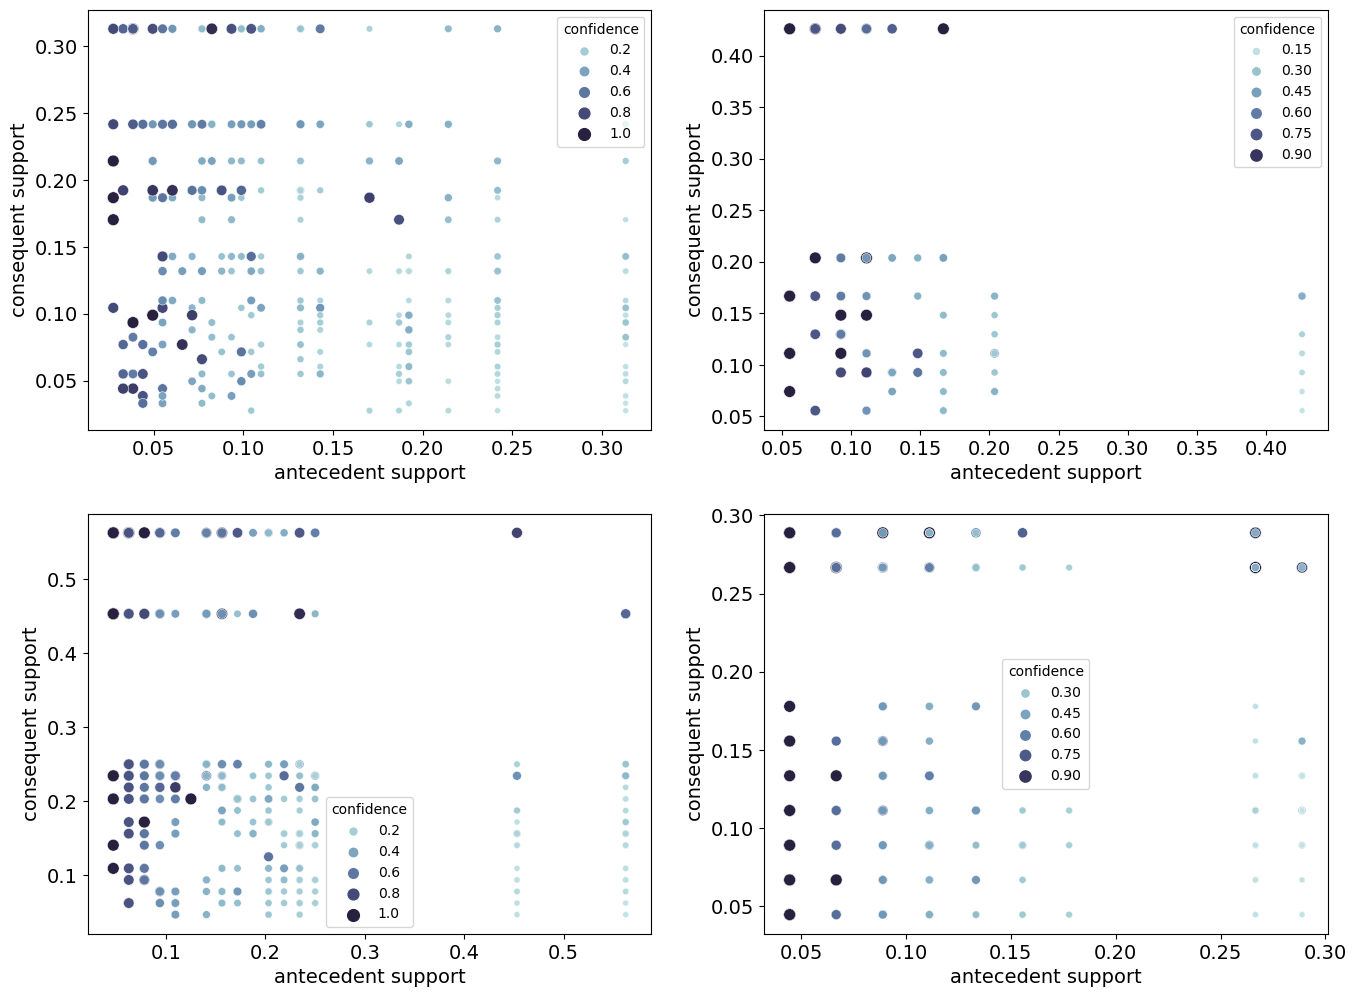

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(ax=axes[0, 0], x="antecedent support", y="consequent support", size="confidence", hue="confidence",
                data=rules_subdfs['tiktok'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), s=50)
axes[0, 0].set_xlabel("antecedent support", fontsize=14)
axes[0, 0].set_ylabel("consequent support", fontsize=14)
axes[0, 0].tick_params(axis='both', which='major', labelsize=14)  # Adjust font size of tick labels

sns.scatterplot(ax=axes[0, 1], x="antecedent support", y="consequent support", size="confidence", hue="confidence",
                data=rules_subdfs['facebook'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
                s=50)
axes[0, 1].set_xlabel("antecedent support", fontsize=14)
axes[0, 1].set_ylabel("consequent support", fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 0], x="antecedent support", y="consequent support", size="confidence", hue="confidence",
                data=rules_subdfs['uber'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
                s=50)
axes[1, 0].set_xlabel("antecedent support", fontsize=14)
axes[1, 0].set_ylabel("consequent support", fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 1], x="antecedent support", y="consequent support", size="confidence", hue="confidence",
                data=rules_subdfs['youtube'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
                s=50)
axes[1, 1].set_xlabel("antecedent support", fontsize=14)
axes[1, 1].set_ylabel("consequent support", fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)

plt.show()


In [24]:
# Generate association rules without performing additional pruning
for app in rules_subdfs.keys():
    print(app, len(rules_subdfs[app]))
    rules = rules_subdfs[app][rules_subdfs[app]['antecedent support'] <= rules_subdfs[app]['consequent support']]
    rules_subdfs[app] = rules
    print('greater consequent support than antecedent support', app, len(rules_subdfs[app]))
#rules_subdfs  

tiktok 282
greater consequent support than antecedent support tiktok 143
facebook 82
greater consequent support than antecedent support facebook 44
uber 324
greater consequent support than antecedent support uber 165
youtube 272
greater consequent support than antecedent support youtube 147


### Optimality of the support-confidence border

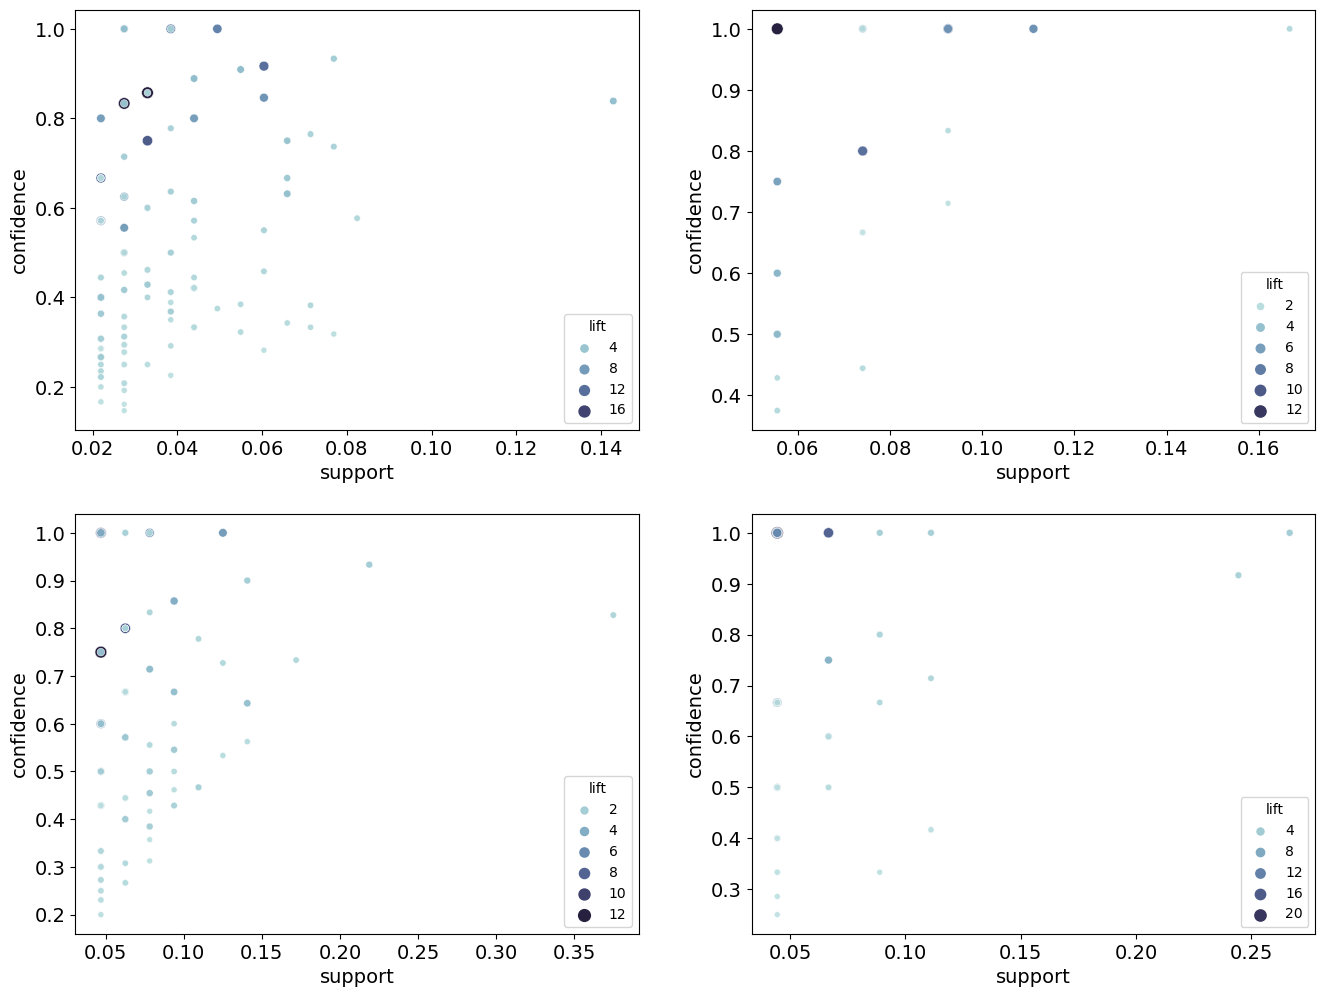

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(ax=axes[0, 0], x="support", y="confidence", size="lift", hue="lift",
                data=rules_subdfs['tiktok'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
axes[0, 0].set_xlabel("support", fontsize=14)
axes[0, 0].set_ylabel("confidence", fontsize=14)
axes[0, 0].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[0, 1], x="support", y="confidence", size="lift", hue="lift",
                data=rules_subdfs['facebook'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
axes[0, 1].set_xlabel("support", fontsize=14)
axes[0, 1].set_ylabel("confidence", fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 0], x="support", y="confidence", size="lift", hue="lift",
                data=rules_subdfs['uber'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
axes[1, 0].set_xlabel("support", fontsize=14)
axes[1, 0].set_ylabel("confidence", fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 1], x="support", y="confidence", size="lift", hue="lift",
                data=rules_subdfs['youtube'], palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
axes[1, 1].set_xlabel("support", fontsize=14)
axes[1, 1].set_ylabel("confidence", fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)

plt.show()


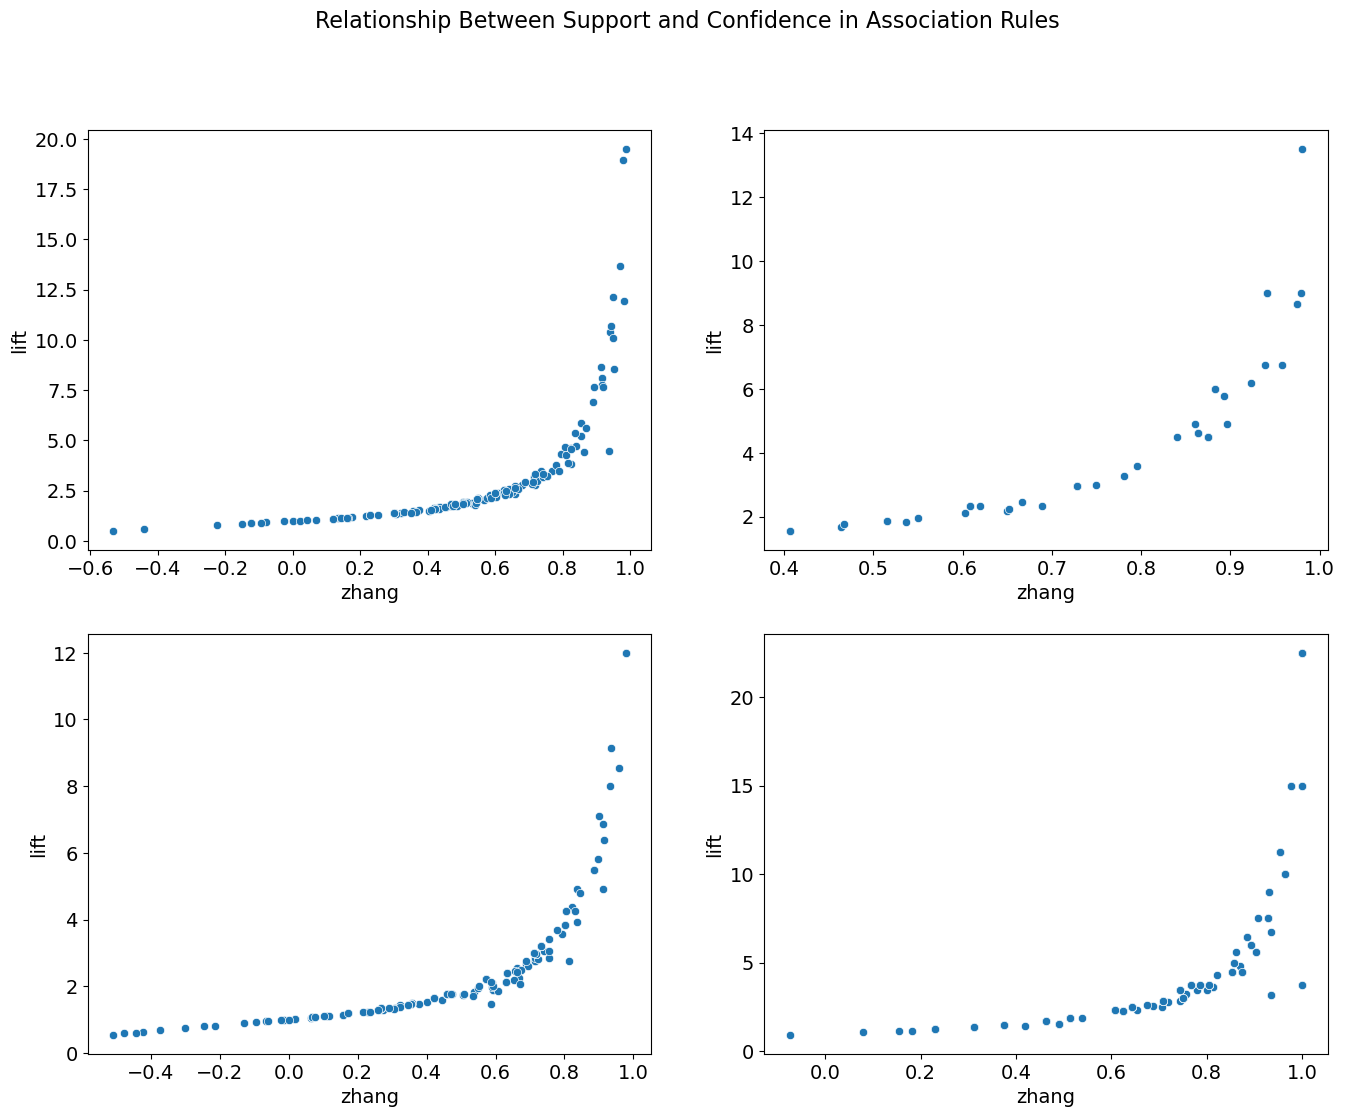

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(ax=axes[0, 0], x="zhangs_metric", y="lift", color='#1f77b4', data=rules_subdfs['tiktok'])
axes[0, 0].set_xlabel('zhang', fontsize=14)
axes[0, 0].set_ylabel('lift', fontsize=14)
axes[0, 0].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[0, 1], x="zhangs_metric", y="lift", color='#1f77b4', data=rules_subdfs['facebook'])
axes[0, 1].set_xlabel('zhang', fontsize=14)
axes[0, 1].set_ylabel('lift', fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 0], x="zhangs_metric", y="lift", color='#1f77b4', data=rules_subdfs['uber'])
axes[1, 0].set_xlabel('zhang', fontsize=14)
axes[1, 0].set_ylabel('lift', fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)

sns.scatterplot(ax=axes[1, 1], x="zhangs_metric", y="lift", color='#1f77b4', data=rules_subdfs['youtube'])
axes[1, 1].set_xlabel('zhang', fontsize=14)
axes[1, 1].set_ylabel('lift', fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle('Relationship Between Support and Confidence in Association Rules', fontsize=16)

plt.show()


## Disassociation rules

In [30]:
#rules_subdfs['tiktok'][rules_subdfs['tiktok']['antecedent support'] <= rules_subdfs['tiktok']['consequent support']]
#rules_subdfs['tiktok'][rules_subdfs['tiktok']['zhangs_metric'] <= 0] 
#rules_subdfs['facebook'][rules_subdfs['facebook']['zhangs_metric'] <= 0]  
#rules_subdfs['uber'][rules_subdfs['uber']['zhangs_metric'] <= 0]  
#rules_subdfs['youtube'][rules_subdfs['youtube']['zhangs_metric'] <= 0] 

for app in rules_subdfs.keys():
    print(app)
    rules_subdfs[app][rules_subdfs[app]['zhangs_metric'] <= 0].to_csv(f'disassociation_rules_{app}.csv')
    print(len(rules_subdfs[app][rules_subdfs[app]['zhangs_metric'] <= 0]))


tiktok
11
facebook
0
uber
17
youtube
1


# Strong Association Rules

## TikTok

In [31]:
strong_rules_tiktok = rules_subdfs['tiktok'][(rules_subdfs['tiktok']['zhangs_metric'] >= 0.5) & 
                                               (rules_subdfs['tiktok']['lift'] >= 2) &
                                            (rules_subdfs['tiktok']['confidence'] >= 0.4)]
print('All rules: ', len(rules_subdfs['tiktok']))
print('Strong rules: ', len(strong_rules_tiktok))

strong_rules_tiktok .sort_values('zhangs_metric', ascending=True)

All rules:  143
Strong rules:  63


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
258,(spread),(people),0.049451,0.214286,0.021978,0.444444,2.074074,0.011381,1.414286,0.544798
204,(great),(people),0.049451,0.214286,0.021978,0.444444,2.074074,0.011381,1.414286,0.544798
274,(scam),(video),0.054945,0.241758,0.027473,0.500000,2.068182,0.014189,1.516484,0.546512
144,(disable),(discrimination),0.032967,0.313187,0.021978,0.666667,2.128655,0.011653,2.060440,0.548295
185,(wrong),(discrimination),0.038462,0.313187,0.027473,0.714286,2.280702,0.015427,2.403846,0.584000
...,...,...,...,...,...,...,...,...,...,...
197,(girl),(naked),0.071429,0.098901,0.060440,0.846154,8.555556,0.053375,5.857143,0.951049
17,(customer),(accountability),0.043956,0.054945,0.032967,0.750000,13.650000,0.030552,3.780220,0.969349
141,(dangerous),(safety),0.032967,0.043956,0.027473,0.833333,18.958333,0.026023,5.736264,0.979545
25,(addict),(addiction),0.065934,0.076923,0.060440,0.916667,11.916667,0.055368,11.076923,0.980749


## Facebook

In [32]:
strong_rules_facebook = rules_subdfs['facebook'][(rules_subdfs['facebook']['zhangs_metric'] >= 0.4) &
                                                 (rules_subdfs['facebook']['lift'] >= 2)&
                                                 (rules_subdfs['facebook']['confidence'] >= 0.3)]
print('All rules: ', len(rules_subdfs['facebook']))
print('Strong rules: ', len(strong_rules_facebook))

strong_rules_facebook.sort_values('confidence', ascending=True)


All rules:  44
Strong rules:  36


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
54,(people),(discrimination),0.148148,0.166667,0.055556,0.375000,2.250000,0.030864,1.333333,0.652174
17,(make),(account),0.129630,0.203704,0.055556,0.428571,2.103896,0.029150,1.393519,0.602837
5,(discrimination),(account),0.166667,0.203704,0.074074,0.444444,2.181818,0.040123,1.433333,0.650000
81,(opinion),(post),0.111111,0.111111,0.055556,0.500000,4.500000,0.043210,1.777778,0.875000
63,(hack),(friend),0.111111,0.111111,0.055556,0.500000,4.500000,0.043210,1.777778,0.875000
10,(identity),(account),0.111111,0.203704,0.055556,0.500000,2.454545,0.032922,1.592593,0.666667
62,(friend),(hack),0.111111,0.111111,0.055556,0.500000,4.500000,0.043210,1.777778,0.875000
80,(post),(opinion),0.111111,0.111111,0.055556,0.500000,4.500000,0.043210,1.777778,0.875000
25,(opinion),(censor),0.111111,0.166667,0.055556,0.500000,3.000000,0.037037,1.666667,0.750000
77,(put),(make),0.092593,0.129630,0.055556,0.600000,4.628571,0.043553,2.175926,0.863946


## Uber

In [33]:
strong_rules_uber = rules_subdfs['uber'][(rules_subdfs['uber']['zhangs_metric'] >= 0.4) & 
                                         (rules_subdfs['uber']['confidence'] >= 0.3) & 
                                               (rules_subdfs['uber']['lift'] >= 2)]
print('All rules: ', len(rules_subdfs['uber']))
print('Strong rules: ', len(strong_rules_uber))

strong_rules_uber.sort_values('confidence', ascending=True)


All rules:  165
Strong rules:  69


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
165,(dangerous),(ride),0.156250,0.187500,0.062500,0.400000,2.133333,0.033203,1.354167,0.629630
42,(bad),(ride),0.156250,0.187500,0.062500,0.400000,2.133333,0.033203,1.354167,0.629630
70,(discrimination),(cancel),0.109375,0.171875,0.046875,0.428571,2.493506,0.028076,1.449219,0.672515
108,(discrimination),(charge),0.109375,0.203125,0.046875,0.428571,2.109890,0.024658,1.394531,0.590643
47,(support),(bad),0.109375,0.156250,0.046875,0.428571,2.742857,0.029785,1.476562,0.713450
...,...,...,...,...,...,...,...,...,...,...
293,(report),(safety),0.046875,0.453125,0.046875,1.000000,2.206897,0.025635,inf,0.573770
33,(artist),(scam),0.125000,0.203125,0.125000,1.000000,4.923077,0.099609,inf,0.910714
301,(rude),(safety),0.046875,0.453125,0.046875,1.000000,2.206897,0.025635,inf,0.573770
245,(felt),(unsafe),0.046875,0.234375,0.046875,1.000000,4.266667,0.035889,inf,0.803279


## Youtube

In [40]:
strong_rules_youtube = rules_subdfs['youtube'][(rules_subdfs['youtube']['zhangs_metric'] >= 0.7) & 
                                               (rules_subdfs['youtube']['confidence'] >= 0.5) & 
                                               (rules_subdfs['youtube']['lift'] >= 2)]
                                               
print('All rules: ', len(rules_subdfs['youtube']))
print('Strong rules: ', len(strong_rules_youtube))

strong_rules_youtube.sort_values('zhangs_metric', ascending=True)


All rules:  147
Strong rules:  86


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
85,(content),(inappropriate content),0.155556,0.288889,0.111111,0.714286,2.472527,0.066173,2.488889,0.705263
142,(full),(news),0.088889,0.266667,0.066667,0.750000,2.812500,0.042963,2.933333,0.707317
45,(platform),(censorship),0.088889,0.177778,0.044444,0.500000,2.812500,0.028642,1.644444,0.707317
42,(free),(censorship),0.088889,0.177778,0.044444,0.500000,2.812500,0.028642,1.644444,0.707317
40,(delete),(censorship),0.088889,0.177778,0.044444,0.500000,2.812500,0.028642,1.644444,0.707317
...,...,...,...,...,...,...,...,...,...,...
174,(law),(private),0.044444,0.044444,0.044444,1.000000,22.500000,0.042469,inf,1.000000
39,(restriction),(block),0.044444,0.044444,0.044444,1.000000,22.500000,0.042469,inf,1.000000
38,(block),(restriction),0.044444,0.044444,0.044444,1.000000,22.500000,0.042469,inf,1.000000
244,(scam),(scammer),0.066667,0.066667,0.066667,1.000000,15.000000,0.062222,inf,1.000000


In [35]:
strong_rules_tiktok.antecedents = strong_rules_tiktok.antecedents.apply(lambda x: next(iter(x)))
strong_rules_tiktok.consequents = strong_rules_tiktok.consequents.apply(lambda x: next(iter(x)))
strong_rules_tiktok.to_csv('strong_rules_tiktok.csv')

strong_rules_facebook.antecedents = strong_rules_facebook.antecedents.apply(lambda x: next(iter(x)))
strong_rules_facebook.consequents = strong_rules_facebook.consequents.apply(lambda x: next(iter(x)))
strong_rules_facebook.to_csv('strong_rules_facebook.csv')

strong_rules_uber.antecedents = strong_rules_uber.antecedents.apply(lambda x: next(iter(x)))
strong_rules_uber.consequents = strong_rules_uber.consequents.apply(lambda x: next(iter(x)))
strong_rules_uber.to_csv('strong_rules_uber.csv')

strong_rules_youtube.antecedents = strong_rules_youtube.antecedents.apply(lambda x: next(iter(x)))
strong_rules_youtube.consequents = strong_rules_youtube.consequents.apply(lambda x: next(iter(x)))
strong_rules_youtube.to_csv('strong_rules_youtube.csv')

/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_64680/1987013407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_rules_tiktok.antecedents = strong_rules_tiktok.antecedents.apply(lambda x: next(iter(x)))
/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_64680/1987013407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_rules_tiktok.consequents = strong_rules_tiktok.consequents.apply(lambda x: next(iter(x)))
/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_646